In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 선형회귀모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환->표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse

## 1. 데이터 불러오기

In [2]:
df_raw = pd.read_csv("C:/Users/Myung-jin/21aibigdata/bigdata/체질검사.CSV")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


## 2. 데이터 전처리
#### 파생변수 BMI를 생성한다.

In [3]:
df_raw["BMI"] = (df_raw["WEIGHT"]*0.45) / (df_raw["HEIGHT"]*2.54*0.01)
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,89.048579
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,41.773726
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,45.972470
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,39.811682
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,60.623770


## 3. 변수 간의 경향성 파악
### 그래프 분석

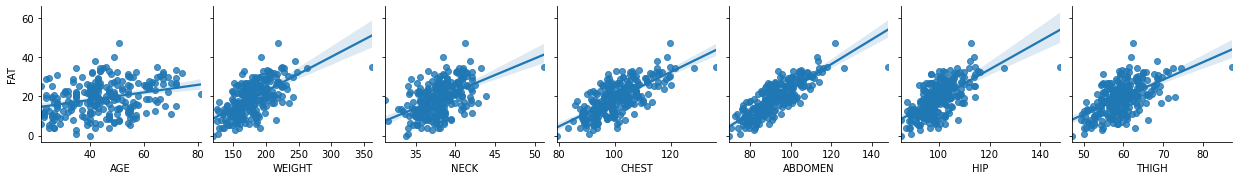

In [4]:
# 산점도 행렬:목표변수와 설명변수 지정. kind ="scatter"| "reg" 
sns.pairplot(df_raw, y_vars="FAT", x_vars=["AGE", "WEIGHT", "NECK", "CHEST", "ABDOMEN", "HIP", "THIGH"], kind = "reg")

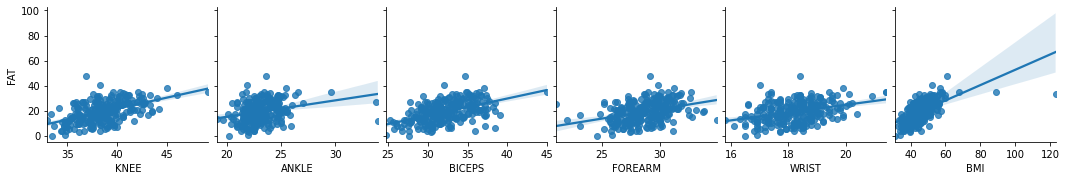

In [5]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["KNEE", "ANKLE", "BICEPS", "FOREARM", "WRIST", "BMI"], kind = "reg")

- 목표변수에 대해 설명변수들의 산점도 행렬(선형관계)을 봤을 때, WEIGHT, THIGH 등 설명변수에서 이상치가 있는 것 같다.

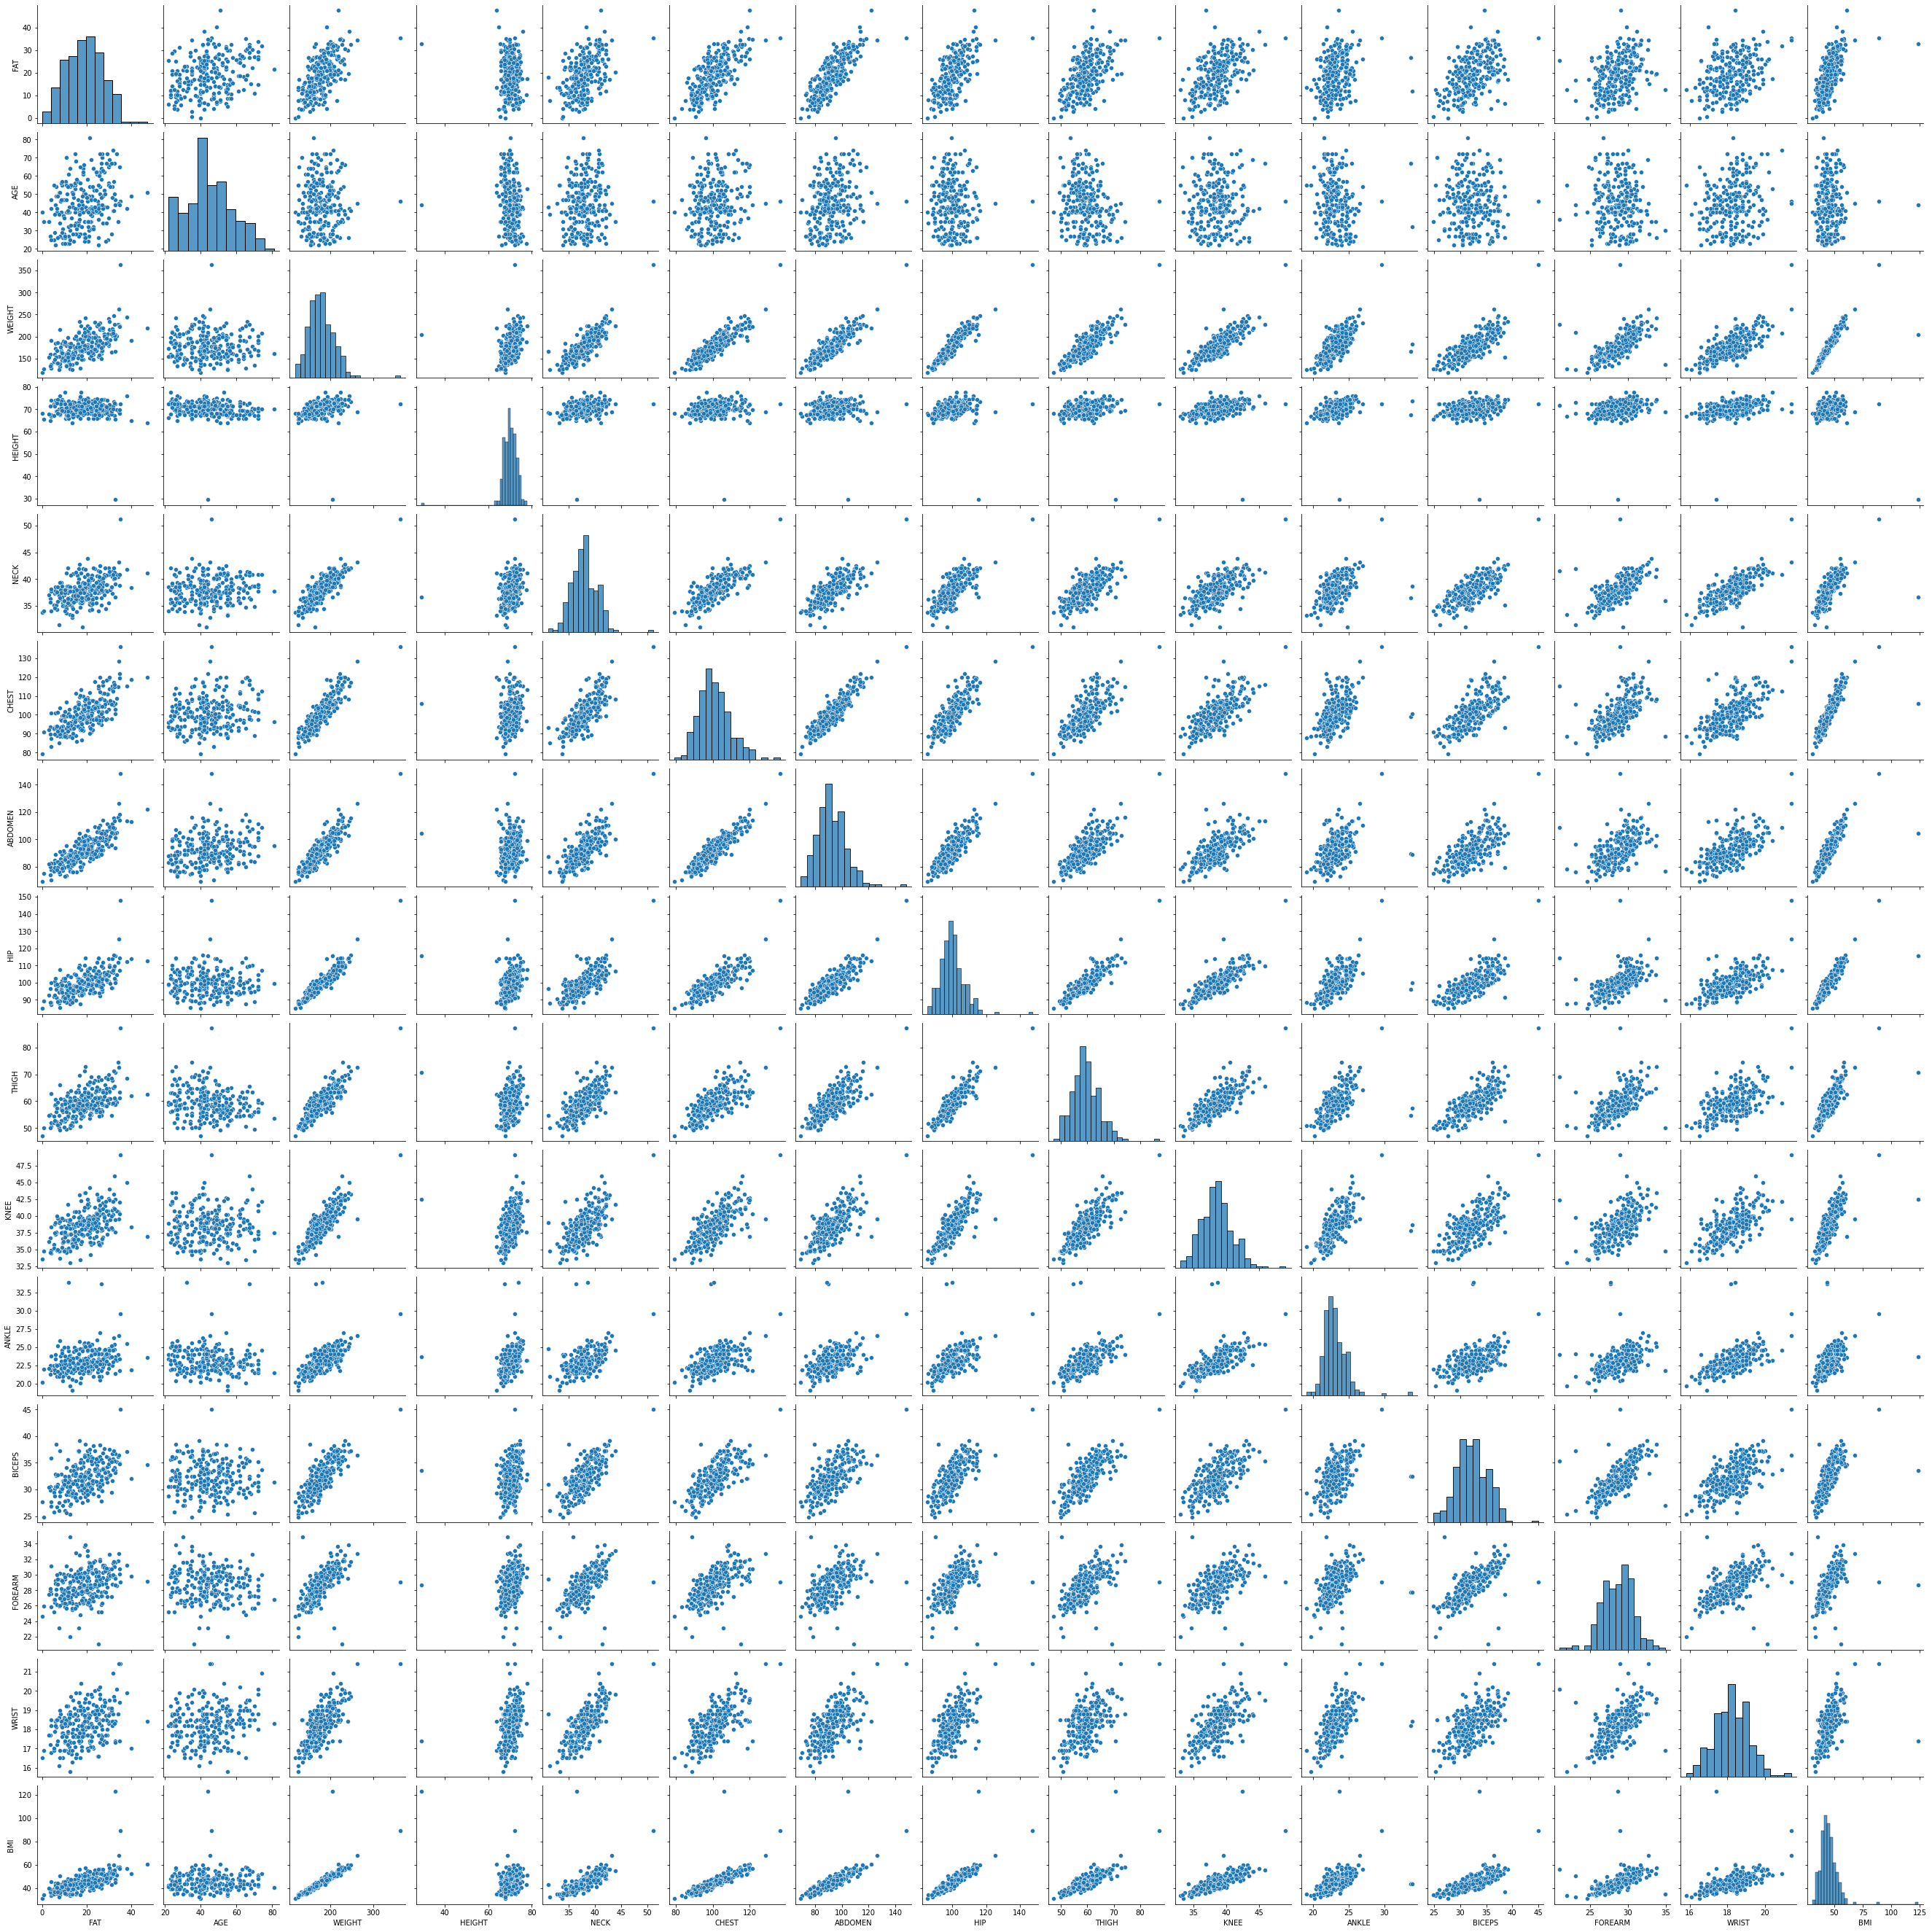

In [6]:
sns.pairplot(df_raw)

- 전체 숫자형 변수에 대한 산점도 행렬을 봤을 때, 목표변수와 선형관계가 있는 설명변수가 WEIGHT, NECK 등 확인된다. 
- 선형관계를 보이는 설명변수가 많으므로 상관계수를 통해 변수간 연관된 정도가 있는지 확인해보자.

### 상관관계 분석

In [7]:
# 상관관계 분석
df_raw.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,0.610
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,0.037
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730,0.819
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322,-0.249
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.652
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,0.771
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,0.789
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,0.835
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,0.775
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,0.710


- 상관계수는 -1에서 1까지의 값을 가지고 절대값 1에 가까울수록 직선에 가까운, 선형 관계이다.
- 목표변수 FAT 변수에 대해 CHEST, ABDOMEN이 높은 양의 선형관계를 가짐을 알 수 있다.
- CHEST - ABDOMEN 사이 등 설명변수 간에도 선형관계가 있음을 알 수 있다. 따라서 자세히 알아보고 변수 조정을 위해 다중공선성을 확인해보아야한다.
- 그 전에 원래 설명변수 전체에 대한 회귀 모델을 생성해보고 분석해보고자 한다.

## 4. 회귀 모델 생성 - 다중공선성 확인

#### - 설명 변수 전체에 대한 회귀 모델 생성

In [8]:
# 선형 회귀 분석
reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + \
ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI", data = df_raw)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     50.61
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           5.07e-63
Time:                        00:54:32   Log-Likelihood:                -718.10
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     237   BIC:                             1519.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -29.2532     27.035     -1.082      0.2

① 데이터의 갯수(분석 자료수)는 252개이다. x변수의 갯수(모델 자유도)는 14개이므로, 잔차의 자유도는 252-14 = 237이다.  
② ANOVA(분산분석) 결과 p값이 유의수준 0.05보다 낮으므로 이 모델은 회귀모델로서 의미가 있다.  
③ R-square는 결정계수로 1에 가까울수록 모형의 설명력이 좋다는 뜻이다. 0.749로 모델을 통해 설명변수를 74.9% 설명할 수 있다는 뜻이다.  
   모델의 설명력은 좋은 편이다.  
**③-1 수정 결정계수는 이 문제같은 다중회귀분석에서 R-squre 대신 해석에 사용된다. 0.735로 설명변수를 73,5% 설명할 수 있다.**  
④ p-value를 통해 기울기가 있는, 의미있는 변수인지 판단을 하려고 한다. p가 유의수준 0.05보다 작아야 유의성이 있는데,
   ABDOMEN, FOREARM, WRIST의 p값이 0.05보다 작으므로 의미있다.  
⑤ 잔차의 p-value는 유의수준 0.05보다 크므로 귀무가설을 채택한다. 즉, 잔차는 정규성이 있다.  
⑥ ④에서 분석했을 때, p-value를 통해 가장 유의하지 않은 설명변수 KNEE를 체크해두고 다중공선성을 확인해보고자 한다.   

#### - 설명 변수 전체 간 다중공선성 확인

In [9]:
# 설명변수간의 다중공선성 확인 : 설명변수 데이터 생성 및 상수항 추가
df_raw_x = df_raw.drop("FAT", axis = 1)

# statsmodels의 상수항 추가 함수 적용
df_raw_x_const = add_constant(df_raw_x) 

# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
10,ANKLE,1.920
12,FOREARM,2.199
1,AGE,2.252
13,WRIST,3.378
11,BICEPS,3.674
4,NECK,4.457
9,KNEE,4.797
8,THIGH,8.003
5,CHEST,10.066
6,ABDOMEN,12.570


→ WEIGHT의 VIF가 94.865로 가장 높고 그 다음으로는 BMI도 높은 편이다.   
다중공선성이 발생했으므로 가장 VIF가 높은 변수를 제외한 모델에 대해 검토하고 다시 평가를 해보고자 한다. 

#### 1개의 설명변수 제외 후 다중공선성 확인

In [12]:
# 다중공선성 높은 변수 제거 후 공선성 재확인
df_raw_x = df_raw.drop(["FAT", "WEIGHT"], axis = 1)

# statsmodels의 상수항 추가 함수 적용
df_raw_x_const = add_constant(df_raw_x) 

# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
9,ANKLE,1.863
11,FOREARM,2.196
1,AGE,2.227
12,WRIST,3.349
10,BICEPS,3.524
2,HEIGHT,3.828
3,NECK,4.030
8,KNEE,4.797
7,THIGH,7.777
4,CHEST,8.183


- WEIGHT 변수 하나 제거했는데 나머지 설명변수의 VIF도 크게 낮아졌다. 어느정도 다중공선성 문제가 해결되었다고 볼 수 있다.

#### - WEIGHT 제외한 설명 변수에 대한 회귀 모델 생성

In [13]:
# 선형 회귀 분석
reg_model = smf.ols(formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + \
ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI", data = df_raw)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     54.13
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.79e-63
Time:                        00:55:36   Log-Likelihood:                -719.15
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     238   BIC:                             1516.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3098      7.675      0.952      0.3

① 데이터의 갯수(분석 자료수)는 252개이지만, WEIGHT 삭제로 x의 갯수(모델 자유도)는 13개이다.  
② ANOVA(분산분석) 결과 p값이 유의수준 0.05보다 낮으므로 이 모델은 회귀모델로서 여전히 의미가 있다.    
③ 수정 결정계수가 1에 가까울수록 모형의 설명력이 좋다는 뜻이다.아주 약간 값이 하락했지만 여전히 설명력은 있는 모델이라고 할 수 있다.  
④ p-value를 통해 기울기가 있는, 의미있는 변수인지 판단을 하려고 한다. p가 유의수준 0.05보다 작아야 유의성이 있는데,  
   KNEE는 여전히 가장 의미있지 않는 변수이다.(기울기가 0이다)  
⑤ 잔차의 p-value는 유의수준 0.05보다 크므로 귀무가설을 채택한다. 즉, 잔차는 정규성이 있다.  

## 5. REF 이용한 변수 선택 및 모델 생성

In [14]:
# RFE(recursive feature elimination) 함수 : 입력된 모델을 이용하여 변수중요도가 낮은 순으로 순차적으로 제거
df_raw_y = df_raw["FAT"]

model = LinearRegression()
# 전체 변수 중 5개의 변수가 남을 때까지 변수 선택
rfe = RFE(estimator = model, n_features_to_select = 5).fit(df_raw_x, df_raw_y)
# 선택된 변수
selected_cols = df_raw_x.columns[rfe.support_]
# 제거된 변수
removed_cols = df_raw_x.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_cols)) 
print("Removed Variables : {}".format(removed_cols))


Selected Variables : Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables : Index(['AGE', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS', 'BMI'], dtype='object')


- 선형회귀를 돌려서 5개의 유의미한 변수를 선택했다. NECK, ABDOMEN, HIP, FOREARM, WRIST 변수를 선택했음을 알 수 있다.

In [15]:
# 회귀 모델 생성
rfe_reg_model = smf.ols(formula = "FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data = df_raw)

# 적합
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           4.38e-68
Time:                        01:06:22   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7037      6.231      0.434      0.6

① 데이터의 갯수(분석 자료수)는 252개지만 x변수의 갯수(모델 자유도)는 5개를 선택했기 때문에 크게 줄었다.  
② ANOVA(분산분석) 결과 p값이 유의수준 0.05보다 낮으므로 이 모델은 회귀모델로서 여전히 의미가 있다.  
③ 수정 결정계수가 1에 가까울수록 모형의 설명력이 좋다는 뜻이다.아주 약간 값이 하락했지만 여전히 설명력은 있는 모델이라고 할 수 있다.  
④ p-value를 통해 기울기가 있는, 의미있는 변수인지 판단을 하려고 한다. p가 유의수준 0.05보다 작아야 유의성이 있는데,  
   모든 변수가 유의수준 0.05보다 p-value가 작으므로 의미있다.  
⑤ 잔차의 p-value는 유의수준 0.05보다 크므로 귀무가설을 채택한다. 즉, 잔차는 정규성이 있다.   

## 6. 잔차 분석
- 잔차의 정규성, 등분산성, 독립성이 전제조건이므로 확인해보려고 한다.

##### 잔차의 등분산성 검정

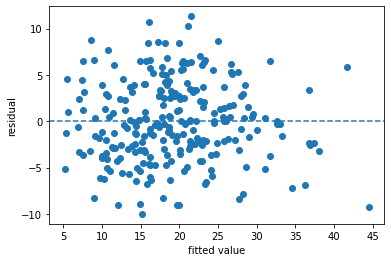

In [16]:
plt.scatter(rfe_reg_result.fittedvalues, rfe_reg_result.resid)
plt.xlabel("fitted value"); plt.ylabel("residual")
plt.axhline(y=0, linestyle = "--")

- y = 0을 기준으로 양쪽으로 경향성이 없이 random하게 산포되어 있으므로 등분산성을 가진다.

##### 잔차의 독립성 검정

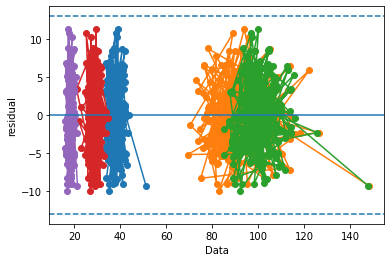

In [18]:
plt.plot(df_raw[["NECK", "ABDOMEN", "HIP", "FOREARM", "WRIST"]], rfe_reg_result.resid, marker = "o")
plt.xlabel("Data")
plt.ylabel("residual")
plt.axhline(y=0, linestyle = "-")
plt.axhline(y=3*np.std(rfe_reg_result.resid), linestyle = "--")
plt.axhline(y=-3*np.std(rfe_reg_result.resid), linestyle = "--")

- y = 0을 기준으로 경향성 없이 random하게 산포되어 있으므로 독립성을 만족한다.

##### 잔차의 정규성 검정
###### - 위의 summary에서 잔차는 정규분포를 따른다는 것을 이미 알고 있지만, 한 번 더 확인을 위해 실행해보았다.

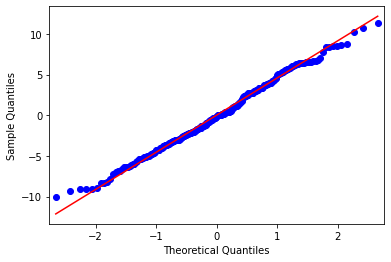

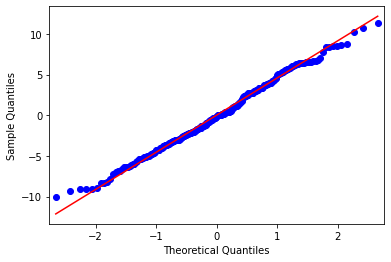

In [20]:
qqplot(rfe_reg_result.resid, line="q")

In [21]:
from statsmodels.stats.stattools import omni_normtest
omni_normtest(rfe_reg_result.resid, axis = 0)

NormaltestResult(statistic=3.6952734095022093, pvalue=0.15760920360555114)

- 정규분포 직선이 빨간색 선을 중심으로 분포하고 있다.
- p-value가 유의수준 0.05보다 크기 때문에 귀무가설을 채택하므로 정규성이 있다.

## 7. 최종 모델의 회귀식과 변수 중요도 확인
- 모델이 적합하고, 잔차의 가정 또한 모두 만족하기 때문에 최종 모델을 선정하고자 한다.

#### → 위의 summary에서 계수를 참조하여 도출해낸 최종 회귀식은,   
#### $\hat{y}$ = 2.7037 - 0.6012 ***NECK*** + 0.9743 ***ABDOMEN*** - 0.3316 ***HIP*** + 0.4095 ***FOREARM*** - 1.6180. ***WRIST*** 

#### 변수 중요도 확인
 - 단위가 다름에 따라 발생하는 문제를 방지하기 위해 표준화 필요

<AxesSubplot:>

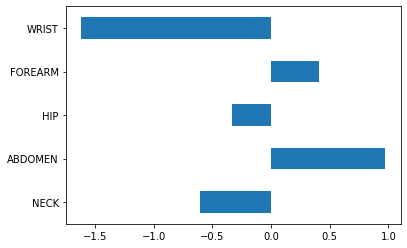

In [22]:
#비표준화 회귀계수 기준
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y = "Coef", legend = False)

중요도는 회귀계수의 절대값의 크기이다.
- WRIST가 가장 중요하다는 것을 알 수 있다. 즉 손목이 얇을수록 FAT(비만도)가 높다.
- ABDOMEN(복부 둘레)가 커질수록 FAT(비만도)가 높음을 알 수 있다.

In [25]:
# 설명변수 표준화 적용  표준화 회귀계수 산출 목적
scaler = StandardScaler()

# Scale 변환대상 변수 : 일반적으로 설명변수
cols = df_raw_x.columns

# Scale 변환
np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns = cols)

# 목표변수 추가
df_scaled["FAT"]= df_raw["FAT"]
reg_model_scaled = smf.ols(formula = "FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()

print(reg_result_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           4.38e-68
Time:                        01:39:23   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.276     69.362      0.0

→ 표준화를 하였지만 수정 결정계수와 결정계수가 동일하다. 즉, 모델의 설명력에는 변화가 없다는 뜻이다.

<AxesSubplot:>

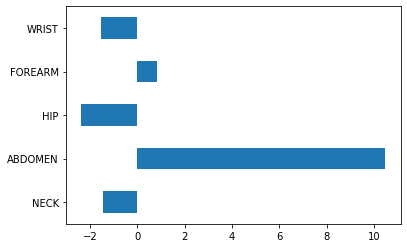

In [24]:
reg_result_scaled_coef = pd.DataFrame({"Coef": reg_result_scaled.params.values[1:]}, index = selected_cols)
reg_result_scaled_coef.plot.barh(y = "Coef", legend = False)

→ 단지 표준화 후, 중요도 크기가 변한 것을 알 수 있다.
    - 표준화 후에는 ABDOMEN(복부 둘레)의 중요도가 크게 증가했고, WRIST(손목)의 중요도는 줄었으며, HIP(엉덩이)의 중요도도 증가하였다.